## Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
data_root = '/content/drive/My Drive/dicom/'

In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from albumentations import *
import os

In [5]:
images = []
for fold in tqdm(os.listdir(data_root)):
  count = 0
  for item in os.listdir(data_root + fold + '/9_reg_t1c/'):
    if count == 50:
      count +=1 
      continue
    else:
      images.append(data_root + fold + '/9_reg_t1c/' + item)
      count += 1

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


In [6]:
masks = []
for fold in tqdm(os.listdir(data_root)):
  count = 0
  for item in os.listdir(data_root + fold + '/Label/Label/'):
    if count == 50:
      count += 1
      continue
    else:
      masks.append(data_root + fold + '/Label/Label/' + item)
      count += 1

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


In [7]:
images = np.array(images)
masks = np.array(masks)

dataset = np.c_[images, masks]
dataset.shape

(900, 2)

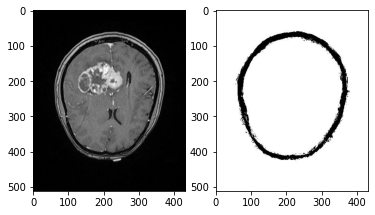

In [8]:
number = 405

f = plt.figure()
f.add_subplot(1,2, 1)
img = cv2.imread(dataset[number][0])
plt.imshow(img)
f.add_subplot(1,2, 2)
mask = cv2.imread(dataset[number][1])
plt.imshow(mask)
plt.show(block=True)

In [9]:
mask.shape

(512, 432, 3)

In [10]:
test = []
for fold in tqdm(os.listdir(data_root)):
  count = 0
  for item in os.listdir(data_root + fold + '/9_reg_t1c/'):
    if count == 50:
      count +=1 
      test.append(data_root + fold + '/9_reg_t1c/' + item)
    else:
      count += 1
      continue

100%|██████████| 10/10 [00:00<00:00, 754.11it/s]


In [11]:
test = np.array(test)
test.shape

(10,)

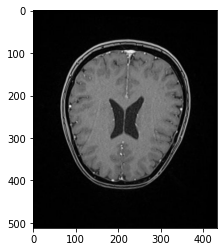

In [12]:
plt.figure()
img = cv2.imread(test[5])
plt.imshow(img)
plt.show(block=True)

In [13]:
img.shape

(512, 432, 3)

# Import

In [14]:
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Input, Dropout
from keras.layers import Dropout
from keras import optimizers
from keras.layers import Flatten, Activation, concatenate, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from keras import backend as K

# Generator

In [15]:
class DataGeneratorFull(Sequence):
    'Generates data for Keras'

    def __init__(self,
                 files,
                 target_df=None,
                 target_size=512,
                 mode='fit',
                 batch_size=8,
                 fill_mode='nearest',
                 rescale=1 / 255.,
                 shuffle=True,
                 augmentation=None):
        self.batch_size = batch_size
        self.files = files
        self.target_size = target_size
        self.mode = mode
        self.shuffle = shuffle
        self.rescale = rescale
        self.aug = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.files[index * self.batch_size:(index + 1) *
                                 self.batch_size]

        if self.mode == 'fit':

            X = np.empty((self.batch_size, self.target_size, self.target_size, 3))
            y = np.empty((self.batch_size, self.target_size, self.target_size, 2))

            images_temp = [elem[0] for elem in batch_files]
            masks_temp = [elem[1] for elem in batch_files]

            for i in range(len(batch_files)):
                image = cv2.imread(images_temp[i])
                mask = cv2.imread(masks_temp[i])
                if self.aug:
                    augmented = self.aug(image=image, mask=mask)
                    image = augmented['image']
                image = cv2.resize(image, (self.target_size, self.target_size))
                image = image * self.rescale
                image = np.array(image)
                X[i, ] = image

                if self.aug:
                    mask = augmented['mask']
                mask = cv2.resize(mask, (self.target_size, self.target_size))
                mask = mask * self.rescale   
                mask = np.array(mask)   
                y[i, :, :, 0] = mask[:, :, 0]
                y[i, :, :, 1] = mask[:, :, 1]
            return X, y

        elif self.mode == 'predict':
            X = []  # np.empty((self.batch_size, 512,512,3))
            for i in batch_files:
                image = cv2.imread(i)
                image = cv2.resize(image, (self.target_size, self.target_size))
                image = image * self.rescale
                X.append(image)
            return np.array(X)
        else:
            raise AttributeError(
                'The parameter mode should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [16]:
train_files, val_files = train_test_split(dataset,
                                          test_size=0.1,
                                          random_state=2020)

In [17]:
test_gen = DataGeneratorFull(test,
                             batch_size=len(test),
                             mode='predict')

# U-net

In [18]:
def Unet(pretrained_weights=None, descr=1, input_size=(512, 512, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(int(1024 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(int(1024 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(int(512 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(int(256 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(int(128 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(int(64 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(4,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(2, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [19]:
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +
                                           smooth)


def dice_loss(y_true, y_pred):
    # smooth = 1.
    # y_true_f = K.flatten(y_true)
    # y_pred_f = K.flatten(y_pred)
    # intersection = y_true_f * y_pred_f
    # score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) +
    #                                                K.sum(y_pred_f) + smooth)
    return 1. - dice_coef(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#Trainig U-net

In [21]:
augmentation = Compose([
    VerticalFlip(p=0.5),
    HorizontalFlip(p=0.5),
    RandomRotate90(p=0.5),
], p=0.75)

In [22]:
TARGET_SIZE = 512

In [23]:
gen_unet = DataGeneratorFull(train_files,
                        batch_size=8, target_size = TARGET_SIZE, augmentation= augmentation)
val_unet = DataGeneratorFull(val_files,
                        batch_size=8, target_size = TARGET_SIZE, augmentation= augmentation)

In [24]:
unet = Unet(pretrained_weights='/content/drive/MyDrive/Skull_segmentation_unet/weights150epochs.h5', input_size=(TARGET_SIZE,TARGET_SIZE,3), descr=8)

In [25]:
unet.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=bce_dice_loss,
              metrics=['acc', dice_coef])

In [ ]:
history_unet = unet.fit(gen_unet,
                        validation_data=val_unet,
                        verbose=2,
                        epochs=150)

Epoch 1/150
101/101 - 44s - loss: 1.0105 - acc: 0.0126 - dice_coef: 0.6612 - val_loss: 0.9789 - val_acc: 0.0019 - val_dice_coef: 0.6718
Epoch 2/150
101/101 - 44s - loss: 0.9503 - acc: 0.0221 - dice_coef: 0.6815 - val_loss: 0.9209 - val_acc: 0.0036 - val_dice_coef: 0.6914
Epoch 3/150
101/101 - 44s - loss: 0.8825 - acc: 0.2884 - dice_coef: 0.7039 - val_loss: 0.8104 - val_acc: 0.9713 - val_dice_coef: 0.7314
Epoch 4/150
101/101 - 44s - loss: 0.6847 - acc: 0.9525 - dice_coef: 0.7800 - val_loss: 0.1322 - val_acc: 0.0640 - val_dice_coef: 0.9640
Epoch 5/150
101/101 - 44s - loss: 0.1007 - acc: 0.7308 - dice_coef: 0.9766 - val_loss: 0.0888 - val_acc: 0.9409 - val_dice_coef: 0.9803
Epoch 6/150
101/101 - 44s - loss: 0.0923 - acc: 0.8131 - dice_coef: 0.9785 - val_loss: 0.0891 - val_acc: 0.8981 - val_dice_coef: 0.9785
Epoch 7/150
101/101 - 44s - loss: 0.0897 - acc: 0.8438 - dice_coef: 0.9789 - val_loss: 0.0871 - val_acc: 0.8313 - val_dice_coef: 0.9783
Epoch 8/150
101/101 - 44s - loss: 0.0885 - acc: 

#Save weights

In [ ]:
unet.save_weights('/content/drive/My Drive/Skull_segmentation_unet/weights150epochs.h5')
print('Saved')

Saved


# *Test* U-net

In [26]:
test_result_unet = unet.predict(test_gen)

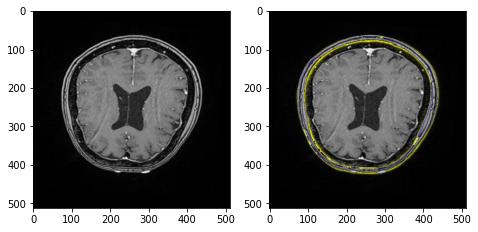

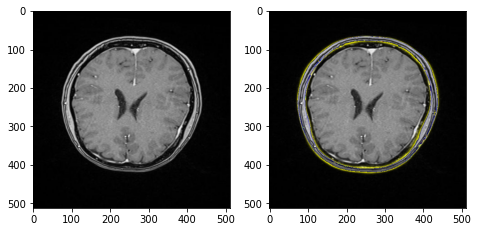

In [27]:
imgs = test_gen.__getitem__(0)
for i in range(2):
  f = plt.figure(figsize=(12,12))
  f.add_subplot(1,3,1)
  plt.imshow((imgs[i] * 255).astype('uint8'))
  mask = test_result_unet[i]
  imgs[i][:,:,0] += (1-mask[:,:,0])
  imgs[i][:,:,1] += (1-mask[:,:,1])
  f.add_subplot(1,3,2)
  plt.imshow((imgs[i]*255).astype('uint8'))
  plt.show(block=True)

In [ ]:
del test_result_unet

1. как сделать норм наложение маски
2. descr


# DeepLab V3

In [11]:
!git clone https://github.com/lattice-ai/DeepLabV3-Plus.git
!mv DeepLabV3-Plus deeplab

Cloning into 'DeepLabV3-Plus'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 884 (delta 174), reused 176 (delta 84), pack-reused 593
Receiving objects: 100% (884/884), 9.56 MiB | 2.68 MiB/s, done.
Resolving deltas: 100% (473/473), done.


In [10]:
!rm -rf deeplab
print('success')

success


In [14]:
%cd /content/deeplab

/content/deeplab


In [15]:
import os
os.listdir()

['.config', 'drive', 'deeplab', 'sample_data']

In [15]:
from deeplabv3plus.model.deeplabv3_plus import DeeplabV3Plus

In [9]:
deeplab = DeeplabV3Plus()

AttributeError: ignored

In [12]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [ ]:
from deeplab.model import load_model
deeplabV3 = load_model('/content/drive/My Drive/Skull_segmentation_deeplabV3/weights41epochs.h5')

ImportError: ignored

In [ ]:
 deeplabV3.compile(optimizer=optimizers.Adam(lr=1e-3),
                 loss=bce_dice_loss,
                 metrics=['acc', dice_coef])

NameError: ignored

In [ ]:
history_deeplabv3 = deeplabV3.fit(gen_unet,
                        validation_data=val_unet,
                        epochs=150,
                        verbose=2,
                        shuffle=True)

Epoch 1/150
101/101 - 164s - loss: 0.1892 - acc: 0.4003 - dice_coef: 0.9487 - val_loss: 0.3779 - val_acc: 0.8413 - val_dice_coef: 0.9695
Epoch 2/150
101/101 - 164s - loss: 0.0872 - acc: 0.3719 - dice_coef: 0.9790 - val_loss: 0.1553 - val_acc: 0.3476 - val_dice_coef: 0.9825
Epoch 3/150
101/101 - 163s - loss: 0.0812 - acc: 0.3550 - dice_coef: 0.9807 - val_loss: 0.1437 - val_acc: 0.7394 - val_dice_coef: 0.9819
Epoch 4/150
101/101 - 164s - loss: 0.0780 - acc: 0.3627 - dice_coef: 0.9815 - val_loss: 0.1180 - val_acc: 0.7055 - val_dice_coef: 0.9843
Epoch 5/150
101/101 - 164s - loss: 0.0756 - acc: 0.3622 - dice_coef: 0.9821 - val_loss: 0.0993 - val_acc: 0.7355 - val_dice_coef: 0.9841
Epoch 6/150
101/101 - 164s - loss: 0.0730 - acc: 0.3637 - dice_coef: 0.9828 - val_loss: 0.1059 - val_acc: 0.8339 - val_dice_coef: 0.9829
Epoch 7/150
101/101 - 164s - loss: 0.0711 - acc: 0.3638 - dice_coef: 0.9833 - val_loss: 0.0983 - val_acc: 0.7905 - val_dice_coef: 0.9840
Epoch 8/150
101/101 - 164s - loss: 0.0694

KeyboardInterrupt: ignored

In [ ]:
deeplabV3.save_weights('/content/drive/My Drive/Skull_segmentation_deeplabV3/weights41epochs.h5')
print('Saved')

Saved


In [ ]:
inputs = Input((512, 512, 3))
model = Model(inputs = inputs, outputs = 2)
deepLabV3 = model.load_weights('/content/drive/MyDrive/Skull_segmentation_deeplabV3/weights41epochs.h5')

AttributeError: ignored

# Test DeepLab V3

In [ ]:
test_result_deeplabV3 = deeplabV3.predict(test_gen)

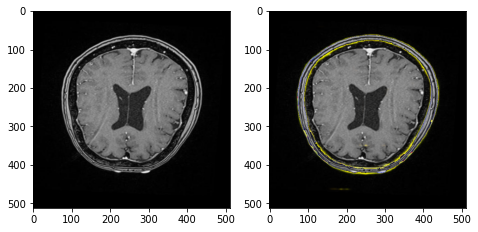

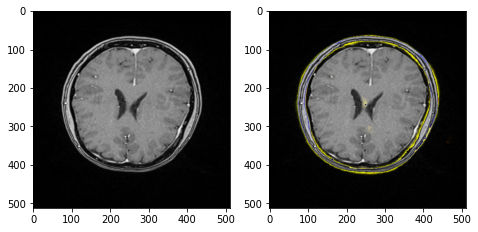

In [ ]:
imgs = test_gen.__getitem__(0)
for i in range(2):
  f = plt.figure(figsize=(12,12))
  f.add_subplot(1,3,1)
  plt.imshow((imgs[i] * 255).astype('uint8'))
  mask = test_result_unet[i]
  imgs[i][:,:,0] += (1-mask[:,:,0])
  imgs[i][:,:,1] += (1-mask[:,:,1])
  f.add_subplot(1,3,2)
  plt.imshow((imgs[i]*255).astype('uint8'))
  plt.show(block=True)

# DoubleU-Net

In [ ]:
!git clone https://github.com/DebeshJha/2020-CBMS-DoubleU-Net
!mv 2020-CBMS-DoubleU-Net doubleunet

In [ ]:
from doubleunet.model import build_model

In [ ]:
double_unet = build_model((512, 512,3))

In [ ]:
%cd /content/doubleunet
from utils import load_model_weight

In [ ]:
double_unet.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=bce_dice_loss,
              metrics=['acc', dice_coef])

In [ ]:
double_unet.fit(gen_unet,
                validation_data=val_unet,
                verbose=2,
                batch_size=2,
                epochs=10)

## Test DoubleU-Net

In [ ]:
test_result_double_unet = double_unet.predict(test_gen)

In [ ]:
imgs = test_gen.__getitem__(0)
for i in range(2):
  f = plt.figure(figsize=(12,12))
  f.add_subplot(1,3,1)
  plt.imshow((imgs[i] * 255).astype('uint8'))
  mask = test_result_double_unet[i]
  imgs[i][:,:,0] += (1-mask[:,:,0])
  imgs[i][:,:,1] += (1-mask[:,:,1])
  f.add_subplot(1,3,2)
  plt.imshow((imgs[i]*255).astype('uint8'))
  plt.show(block=True)